# Import libraries

In [1]:
# Standard Library
import os
import sys
import subprocess
import random
import math
from math import floor
from collections import Counter

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Preprocessing and Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Statistical Analysis
import statsmodels.api as sm
import scipy.stats as stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Clustering
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.decomposition import PCA

# Dimensionality Reduction
import umap

# Deep Learning
import tensorflow as tf
from tensorflow.keras import regularizers, Input, Model, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Module Utilities
import importlib.util

2024-12-12 13:27:45.206459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 13:27:45.209385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:27:45.232432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:27:45.257258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734006465.277927   21312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734006465.28

In [2]:
# Get the current working directory and append the parent directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_directory)

In [3]:
from scripts.create_genotype import simulate_genos
from scripts.parse_vars import parse_variables
from scripts.calculate_true_maf_per_pop import calculate_true_maf_per_pop

# Parse variables

In [4]:
dict = parse_variables('params_geno_simul.txt')
if 'G' not in globals():
    G = int(dict['G'])
if 'L' not in globals():
    L = int(dict['L'])
if 'c' not in globals():
    c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
if 'M' not in globals():
    M = float(dict['M'])

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

# Usefull functions

In [5]:
# Define a function to map values to colors
def map_to_color(x, y, z, df):
    # Check if there's variance to avoid division by zero
    r = x / df['x'].max() if df['x'].max() != 0 else 0  # Red component based on 'x'
    g = y / df['y'].max() if df['y'].max() != 0 else 0  # Green component based on 'y'
    b = z / df['z'].max() if df['z'].max() != 0 else 0  # Blue component based on 'z'
    
    return (r, g, b)

def reduce_reconstruct(block, n_components):
    scaler = StandardScaler()
    scaled_snps = scaler.fit_transform(block)
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_snps)
    
    # Reconstruction
    # Step 1: Inverse PCA transformation
    reconstructed_scaled_snps = pca.inverse_transform(reduced_data)
    
    # Step 2: Reverse scaling
    reconstructed_block = scaler.inverse_transform(reconstructed_scaled_snps)
    
    reconstructed_block = pd.DataFrame(
        data=reconstructed_block,
        columns=block.columns,
        index=block.index
    )
    return reconstructed_block

# Load data

In [6]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/"
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")
humans['z'] = 0
complete = pd.read_pickle(f"{path_geno}/complete_inbred.pkl")

In [7]:
Pxy_s = [f for f in os.listdir(f"{path_pheno}/blocks") if f.startswith('Pxy')]
Dxy_s = [f for f in os.listdir(f"{path_pheno}/blocks") if f.startswith('Dxy')]

In [8]:
Pxy_s

['Pxy_esti_block_2.pkl',
 'Pxy_esti_block_0.pkl',
 'Pxy_esti_block_1.pkl',
 'Pxy_esti_block_4.pkl',
 'Pxy_esti_block_3.pkl']

In [9]:
# Extracting block identifiers for each file
Pxy_blocks = {f.split('_')[-1] for f in Pxy_s}  # Set of block identifiers in Pxy_s
Dxy_blocks = {f.split('_')[-1] for f in Dxy_s}  # Set of block identifiers in Dxy_s

# Finding the intersection of block identifiers
common_blocks = Pxy_blocks & Dxy_blocks

# Filtering both lists to include only files with matching block identifiers
Pxy_s = [f for f in Pxy_s if f.split('_')[-1] in common_blocks]
Dxy_s = [f for f in Dxy_s if f.split('_')[-1] in common_blocks]

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


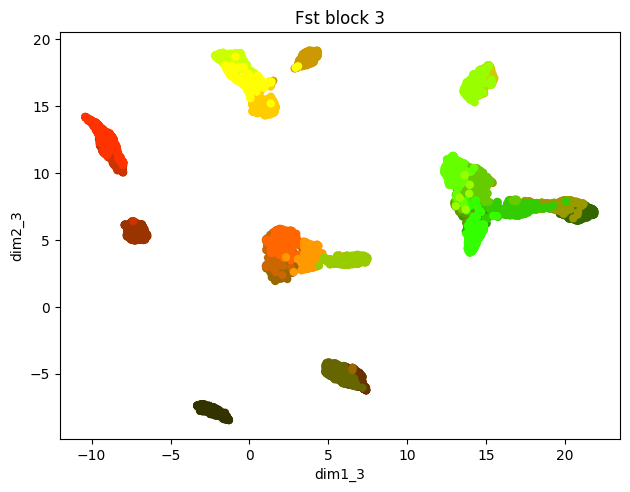

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


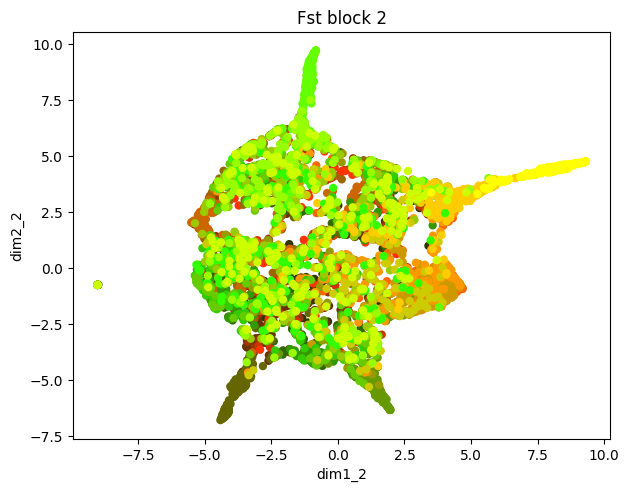

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


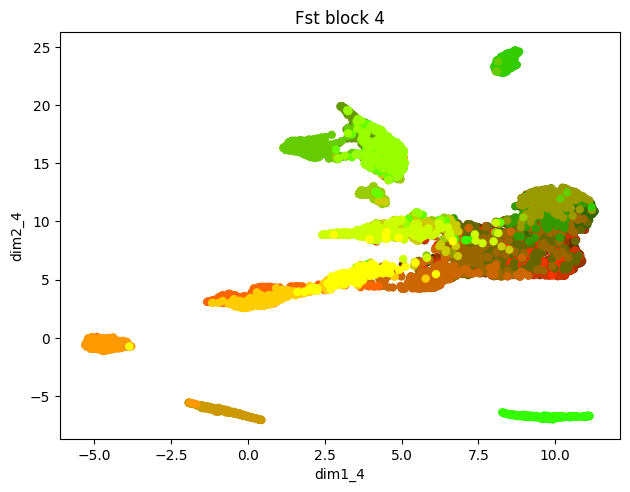

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


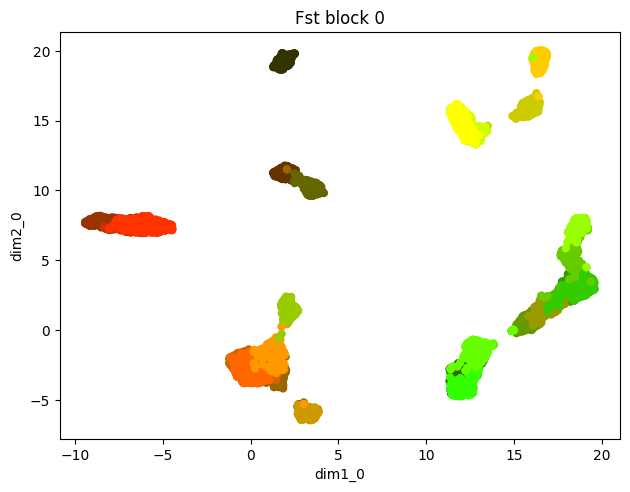

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


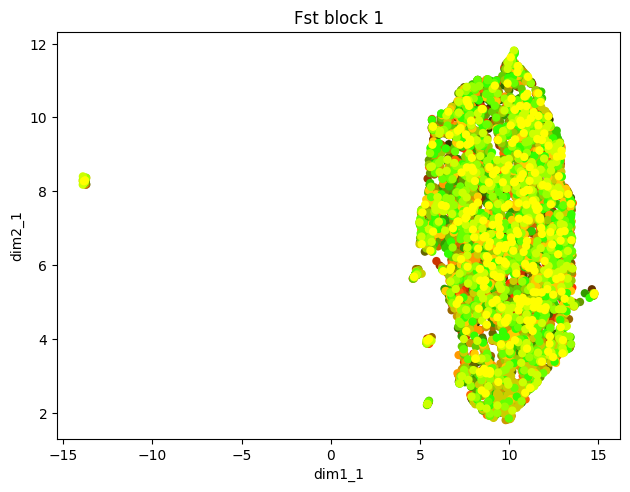

In [10]:
for block in common_blocks:
    nr_block = int(block.split('.')[0])
    Pxy = pd.read_pickle(f"{path_pheno}/blocks/Pxy_esti_block_{block}")
    Dxy = pd.read_pickle(f"{path_pheno}/blocks/Dxy_esti_block_{block}")
    Fst = (Dxy - Pxy)/Dxy
    Fst = abs(Fst.round(5))
    # Convert dissimilarity to distances if required
    reducer = umap.UMAP(metric='precomputed', random_state=42)
    embeddings = reducer.fit_transform(Fst)
    humans[[f"dim1_{nr_block}", f"dim2_{nr_block}"]] = embeddings

    colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
    sns.scatterplot(x=f"dim1_{nr_block}", y=f"dim2_{nr_block}", data=humans, color=colors, linewidth=0)
    
    # Adjust layout
    plt.tight_layout()
    plt.title(f"Fst block {nr_block}")
    # Show the plots
    plt.show()
    plt.close()